In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/eqtl/matched/leafcutter"

In [5]:
models = [
    #"CADD.RawScore",
    #"phyloP",
    #"phastCons",
    #"phyloP-Zoonomia",
    #"SpliceAI",
    #"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression",
    "LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
]

embedding_models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
    "LongSafari/hyenadna-large-1m-seqlen-hf",
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
}

V = pd.read_parquet(f"../../{dataset_path}/test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression,multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression
0,1,690060,A,C,0.994126,0.038760,True,0,-0.330015,-0.281513,-0.925450,-0.318426,-0.324518
1,1,727717,G,C,0.001489,0.180818,False,90,-0.731116,-0.592554,-0.895118,-0.682238,-0.740159
2,1,792461,G,A,0.008431,0.054545,False,383,-0.359175,-0.351351,-0.839876,-0.357645,-0.407463
3,1,794299,C,G,0.009810,0.229965,False,720,-0.643110,-0.540095,-0.833511,-0.581841,-0.641858
4,1,794707,T,C,0.003659,0.053030,False,330,-0.440865,-0.581426,-0.832128,-0.370117,-0.479228
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,X,154864799,G,A,0.009303,0.017241,False,8936,-0.347963,-0.307425,-0.265273,-0.276573,-0.375480
17992,X,155329596,C,T,0.006108,0.282998,False,8822,-0.269467,-0.145834,-0.136622,-0.256603,-0.225761
17993,X,155655744,G,A,0.008496,0.291332,False,8995,-0.293543,-0.093620,-0.088060,-0.286826,-0.277671
17994,X,155705325,G,A,0.007774,0.471574,False,8923,-0.245334,-0.242700,-0.090541,-0.292879,-0.159460


In [6]:
"""
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()
""";

In [7]:
V.dropna(
    subset=models,
    inplace=True
)
V

,chrom,pos,ref,alt,pip,maf,label,match_group,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression,multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression
0,1,690060,A,C,0.994126,0.038760,True,0,-0.330015,-0.281513,-0.925450,-0.318426,-0.324518
1,1,727717,G,C,0.001489,0.180818,False,90,-0.731116,-0.592554,-0.895118,-0.682238,-0.740159
2,1,792461,G,A,0.008431,0.054545,False,383,-0.359175,-0.351351,-0.839876,-0.357645,-0.407463
3,1,794299,C,G,0.009810,0.229965,False,720,-0.643110,-0.540095,-0.833511,-0.581841,-0.641858
4,1,794707,T,C,0.003659,0.053030,False,330,-0.440865,-0.581426,-0.832128,-0.370117,-0.479228
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,X,154864799,G,A,0.009303,0.017241,False,8936,-0.347963,-0.307425,-0.265273,-0.276573,-0.375480
17992,X,155329596,C,T,0.006108,0.282998,False,8822,-0.269467,-0.145834,-0.136622,-0.256603,-0.225761
17993,X,155655744,G,A,0.008496,0.291332,False,8995,-0.293543,-0.093620,-0.088060,-0.286826,-0.277671
17994,X,155705325,G,A,0.007774,0.471574,False,8923,-0.245334,-0.242700,-0.090541,-0.292879,-0.159460


In [8]:
V = V[V.duplicated("match_group", keep=False)]
V.label.value_counts()

label
True     8987
False    8987
Name: count, dtype: int64

## Testing

In [9]:
def get_subtitle(n_pathogenic, n_benign):
    return f"n={n_pathogenic} vs. {n_benign}"

pos_prop = []

rows = []
V_c = V
n_pos, n_neg = (V_c.label==True).sum(), (V_c.label==False).sum()
subtitle = get_subtitle(n_pos, n_neg)
pos_prop.append(n_pos/(n_pos+n_neg))

for m in tqdm(models):
    AUROC = roc_auc_score(V_c.label==True, -V_c[m])
    rows.append([m, AUROC])
results = pd.DataFrame(rows, columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
results

100%|██████████| 5/5 [00:00<00:00, 120.44it/s]


,Model,AUROC
1,InstaDeepAI/nucleotide-transformer-2.5b-multi-...,0.746800
4,multiz100way/89/512/256/True/defined.phastCons...,0.738535
3,multiz100way/89/256/128/True/defined.phastCons...,0.735312
0,multiz100way/89/128/64/True/defined.phastCons....,0.729002
2,LongSafari/hyenadna-large-1m-seqlen-hf.Logisti...,0.691671


In [10]:
#results.to_parquet("results_sqtl.parquet", index=False)

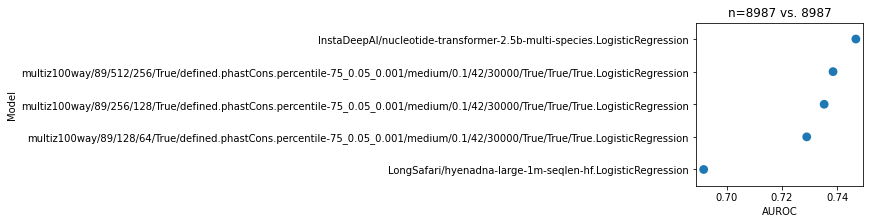

In [11]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.replace({
        "Enformer_l2": "Enformer",
        "GPN-MSA": "GPN-MSA (LLR)",
    }),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);